In [1]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [2]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [5]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol


idx = 0
#myds.display(["fire", idx])


Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [6]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire", 0, ""])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
"""
X = np.load(fm_dir+"feature_matrix_2D.npy")
"""
"Labels"
y = class_ids_aug.copy()

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

print(
    "Remember the convention shown for the toy example, the feature vectors are arranged on the rows."
)

IndexError: tuple index out of range

You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [ ]:
### TO RUN
K = 6  # Number of neighbours for the KNN
model_knn = KNeighborsClassifier(
    n_neighbors=K, weights="distance", algorithm="auto", metric="minkowski"
)  # We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
)  # We explicitly write the default parameters of this LDA classifier once so that you know they exist and can be changed

As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

Shape of the training matrix : (140, 400)
Number of training labels : 140
Accuracy of KNN with fixed train/validation sets : 56.7%


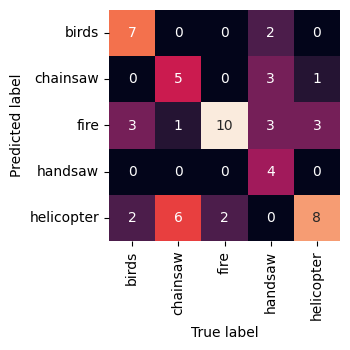

Accuracy of LDA with fixed train/validation sets : 40.0%


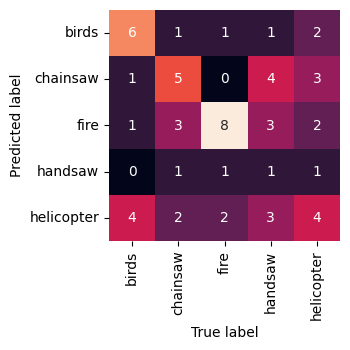

In [ ]:
### TO RUN
"Shuffle then split the dataset into training and testing subsets"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)  # random_state=1
print(f"Shape of the training matrix : {X_train.shape}")
print(f"Number of training labels : {len(y_train)}")

model_knn.fit(X_train, y_train)
model_lda.fit(X_train, y_train)

prediction_knn = model_knn.predict(X_test)
prediction_lda = model_lda.predict(X_test)
accuracy_knn = accuracy(prediction_knn, y_test)
accuracy_lda = accuracy(prediction_lda, y_test)

print(f"Accuracy of KNN with fixed train/validation sets : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_test, classnames)
print(f"Accuracy of LDA with fixed train/validation sets : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_test, classnames)

**Questions**: 
- What would be the expected accuracy if the label predictions were picked at random?
- What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the ``train_test_split`` and tell if your observations are robust.

In [ ]:
### TO COMPLETE
# Answer the questions above

Play with the ``classname`` and the index ``idx`` to pick feature vectors in the dataset ``myds``, listen to the audio associated to the feature vector, and check if you would have been able to predict the right class by your own. Then compare with the prediction given by your classifier.

In [ ]:
### TO RUN
idx = 0
classname = "fire"
#myds.display([classname, idx])
thisfv = myds[classname, idx].reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

prediction_knn = model_knn.predict(mat)
prediction_lda = model_lda.predict(mat)

print("Class predicted by KNN:", prediction_knn[0])
print("Class predicted by LDA:", prediction_lda[0])

('fire', 0)
Class predicted by KNN: fire
Class predicted by LDA: fire


Furthermore, when training a model and comparing different settings, there is a risk that we will end up choosing optimal parameters that only render good result on our specific case of training and validation set, but ``do not generalize well for additional data``. This is called ``overfitting on the validation set``. To alleviate this, we can perform ``cross-validation (CV)``. A basic approach named ``K-fold CV`` involves partitioning the dataset in ``K`` "folds" (subsets) and repetitvely do the following procedure:

- Train the model using `K-1` folds as the training data.
- Test the model using the last fold as the validation data.

The overall performance on each fold is then averaged to obtain the final performance metrics.

In [ ]:
### TO RUN
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

accuracy_knn = np.zeros((n_splits,))
accuracy_lda = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_knn.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_knn = model_knn.predict(X_train[idx_val])
    accuracy_knn[k] = accuracy(prediction_knn, y_train[idx_val])

    model_lda.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_lda = model_lda.predict(X_train[idx_val])
    accuracy_lda[k] = accuracy(prediction_lda, y_train[idx_val])

print(f"Mean accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.mean():.1f}%")
print(
    f"Std deviation in accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.std():.1f}%"
)

print(f"Mean accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.mean():.1f}%")
print(
    f"Std deviation in accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.std():.1f}%"
)

Mean accuracy of KNN with 5-Fold CV: 46.4%
Std deviation in accuracy of KNN with 5-Fold CV: 4.5%
Mean accuracy of LDA with 5-Fold CV: 37.1%
Std deviation in accuracy of LDA with 5-Fold CV: 7.0%


<font size=5 color=#009999> 2.3. Scale mismatch and countermeasure </font> <br>

In real conditions, you will most probably have a different scale between the feature vectors used for training (in simulation) and the ones you feed in your model to make predictions.
This scale mismatch between model training and prediction is difficult to prevent because it depends on multiple factors such as the audio source power, its distance to the microphone, the telecommunication distance. <br>

Below, we illustrate the link between the volume of the audio and its distance to the origin of the feature space. At different emission distances, the exact same sound would be heard at a different volume and the associated feature vector would be located at another position in the *feature space*. Eventually, this would result in a completely different classification, which is undesirable.

<center> <img src="figs/norms.png" alt="" width="350"/> </center>

### Questions:

- How could you avoid this dependency on the volume of the sound?
- What is represented in the hatched centered area? How would you classify feature vectors in this area?

In [ ]:
### TO COMPLETE
# Answer the questions above

Play with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

On which part of the dataset are we computing this confusion matrix?

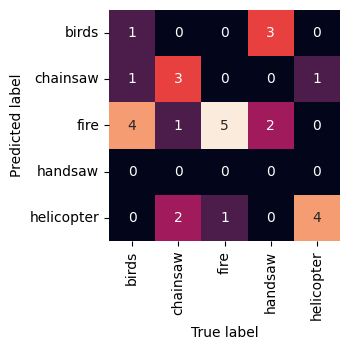

Accuracy of KNN: 46.4%


In [ ]:
### TO RUN
dB_mismatch = 0  # Play with this value
X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)

model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train[idx_learn], y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_scaled)
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
print(f"Accuracy of KNN: {100 * accuracy_knn:.1f}%")

The simplest countermeasure we can think of is to normalise the feature vector (i.e. unitize its norm) prior to use, both for training and testing. Remember how this normalization could be visualized in ``hands_on_classif1_toy_student.ipynb`` <br>
Play again with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

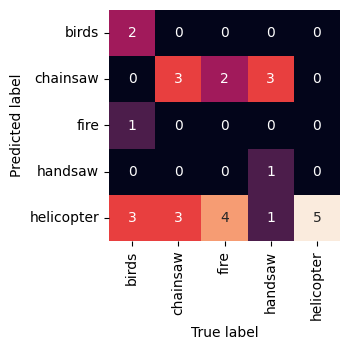

Accuracy of KNN: 39.3%


In [ ]:
### TO RUN
dB_mismatch = 0  # Play with this value

X_learn_normalised = X_train[idx_learn] / np.linalg.norm(
    X_train[idx_learn], axis=1, keepdims=True
)
model_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
model_knn.fit(X_learn_normalised, y_train[idx_learn])

X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)
X_val_normalised = X_val_scaled / np.linalg.norm(X_val_scaled, axis=1, keepdims=True)

prediction_knn = model_knn.predict(X_val_normalised)
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
print(f"Accuracy of KNN: {100 * accuracy_knn:.1f}%")

**Question**: 
- What will happen with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could you deal with it?

In [ ]:
### TO COMPLETE
# Answer the questions above

<font size=5 color=#009999> 2.4. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. It also further reduces the memory cost of the feature vector. To reduce the dimensionality, we will use the ``Principal component analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). Recall: the PCA consists in reducing the dimensionality of data vectors encoded in $\boldsymbol X \in \mathbb R^{d\times N}$ to only $p \ll d$ dimensions as

$$
    \boldsymbol Y = \boldsymbol V_p^\top \boldsymbol X \in \mathbb R^{p\times N},
$$

where the SVD of the covariance matrix writes as $\hat{\boldsymbol\Sigma}_{\boldsymbol X} = \frac{1}{d} \boldsymbol{XX}^\top = \boldsymbol{U\Sigma V}^\top$, and $\boldsymbol V_p$ is the subselection of the first $p$ columns of $\boldsymbol V$. 

For our application, reducing the dimensionality of the data can be helpful for compressing the packet size to be transmitted wirelessly. Indeed, once learned during training, $\boldsymbol V_p$ can be hardcoded on the transmitter side.

Starting with a PCA to 2D for visualization, see how hard it is to separate the classes.

Shape of the reduced training matrix : (112, 2)


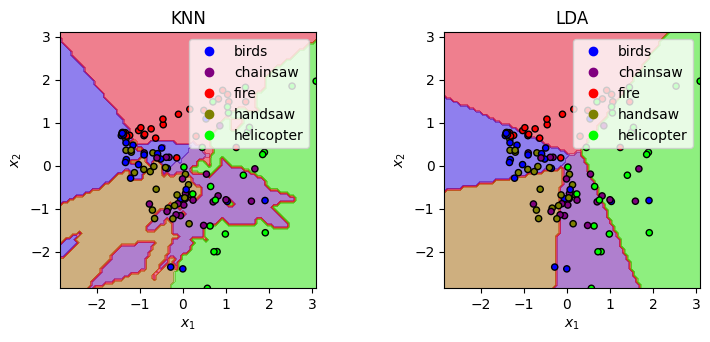

In [ ]:
### TO RUN
n = 2  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced training matrix : {X_learn_reduced.shape}")

y_train_num = np.zeros(y_train.shape)
for i, classname in enumerate(classnames):
    y_train_num[y_train == classname] = i

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K)
model_knn.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train_num[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train_num[idx_val])

fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[0],
    model=model_knn,
    legend=classnames,
    title="KNN",
)
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[1],
    model=model_lda,
    legend=classnames,
    title="LDA",
)
plt.show()

**Question**: 
- From the decision boundaries shown here above, can you explain why the ``handsaw`` class is less often chosen than the other classes for the ``KNN`` classifier?

In [ ]:
### TO COMPLETE
# Answer the questions above

Shape of the reduced learning matrix : (112, 5)
Accuracy of the KNN : 71.4%


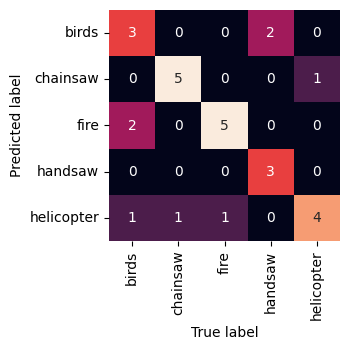

Accuracy of the LDA : 46.4%


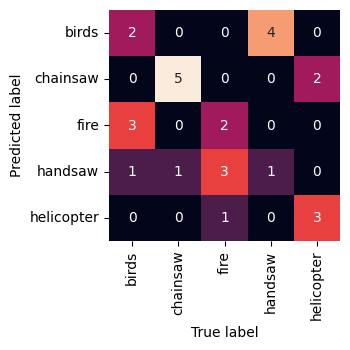

In [ ]:
### TO RUN
n = 5  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced learning matrix : {X_learn_reduced.shape}")

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
model_knn.fit(X_learn_reduced, y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train[idx_val])

print(f"Accuracy of the KNN : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
print(f"Accuracy of the LDA : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_train[idx_val], classnames)

<font size=5 color=#009999> 2.5. Analysis of the hyperparameters </font> <br>

Finally, we can inspect the influence of ``hyperparameters`` as we did for the toy example. <br>
Let us start by analyzing the influence of the number of neighbours $K$ in the KNN. 

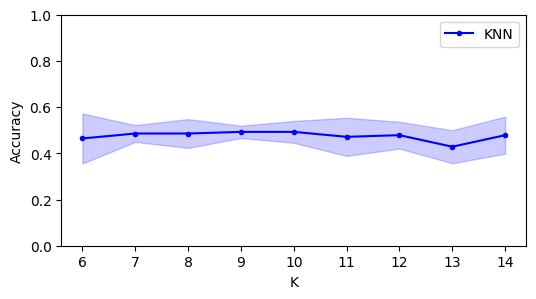

In [ ]:
### TO RUN
Ks = np.arange(6, 15, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6, 3))
plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we consider both ``K`` and the number of principal components ``n``.

In [ ]:
### TO RUN
Ks = np.arange(1, 10)
n_comps = np.arange(2, 15)  # number of principal components kept for the PCA
accuracies_knn = np.zeros((len(Ks), len(n_comps)))
accuracies_lda = np.zeros(len(n_comps))

for j, n in enumerate(n_comps):
    for idx_learn, idx_val in kf.split(X_train, y_train):
        pca = PCA(n_components=n, whiten=True)
        X_learn_reduced = pca.fit_transform(X_train[idx_learn])
        X_val_reduced = pca.transform(X_train[idx_val])
        for i, K in enumerate(Ks):
            model_knn = KNeighborsClassifier(n_neighbors=K)
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i, j] += accuracy(prediction_knn, y_train[idx_val])

        model_lda = LDA()
        model_lda.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_lda = model_lda.predict(X_train[idx_val])
        accuracies_lda[j] += accuracy(prediction_lda, y_train[idx_val])

accuracies_knn /= n_splits
accuracies_lda /= n_splits

fig = plt.figure(figsize=(10, 4))
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]

im0 = axs[0].imshow(100 * accuracies_knn, cmap="jet", origin="lower")
cbar = fig.colorbar(im0, ax=axs[0])
cbar.set_label("Accuracy (%)")
axs[0].set_xlabel("n_PCA")
axs[0].set_ylabel("K")
axs[0].set_xticks(list(np.arange(len(n_comps))))
axs[0].set_xticklabels(list(n_comps))
axs[0].set_yticks(list(np.arange(len(Ks))))
axs[0].set_yticklabels(list(Ks))
axs[0].set_title("KNN")

axs[1].plot(accuracies_lda * 100)
axs[1].set_xlabel("n_PCA")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("LDA")
plt.show()

KeyboardInterrupt: 

**Question**: 
- Do you observe some dependency of the accuracy on these parameters? If so, which one(s)? If not, discuss what it tells about the considered model. 

In [ ]:
### TO COMPLETE
# Answer the question above

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

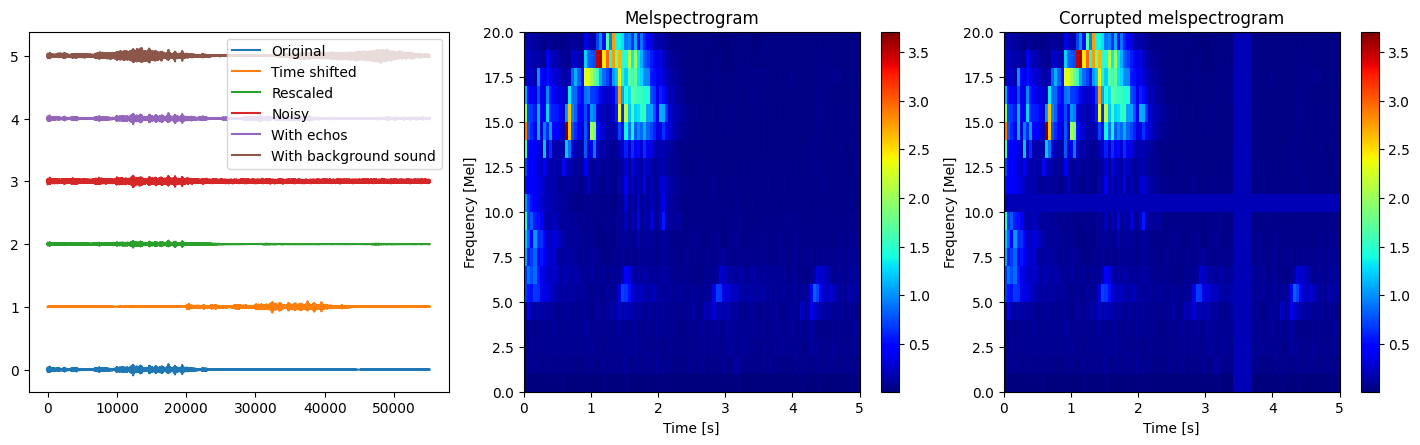

In [ ]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)

#AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.4)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio2, sigma=1e-2)
audio6 = AudioUtil.echo(audio2, 3)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [ ]:
### TO RUN
myds.mod_data_aug(["add_bg"])
y_aug = np.repeat(classnames, dataset.naudio * myds.data_aug_factor)  # Labels

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
for s in range(myds.data_aug_factor):
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)

# X_aug = np.load(fm_dir+"feature_matrix_2D_aug.npy")

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (400, 400)
Number of labels : 400


Mean accuracy with 5-Fold CV: 23.0%
Std deviation in accuracy with 5-Fold CV: 5.4%


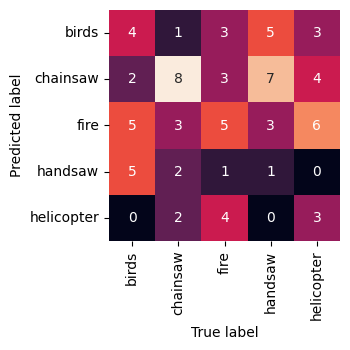

In [ ]:
### TO RUN
K = 10  # Number of neighbours
model = KNeighborsClassifier(n_neighbors=K)

accuracy_aug = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_aug, y_aug)):
    (idx_train, idx_test) = idx
    model.fit(X_aug[idx_train], y_aug[idx_train])
    prediction_aug = model.predict(X_aug[idx_test])
    accuracy_aug[k] = accuracy(prediction_aug, y_aug[idx_test])

print(f"Mean accuracy with 5-Fold CV: {100 * accuracy_aug.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracy_aug.std():.1f}%")
show_confusion_matrix(prediction_aug, y_aug[idx_test], classnames)

**Questions**:
- Can you see an improvement of the classification result compared to the non augmented dataset? Try to interpret your answer by thinking about the distribution of points in a data space (as with the toy example), what does it imply to augment the data in terms of distribution of points in the data space?
- With the ``add_bg`` augmentation technique, where are the additive background signals coming from? It is a good thing?
- What transformations are most likely to be realistic in your application? What is the most efficient way to integrate these alterations in your classification task? ``Hint``: it does not require augmenting your data in Python.

In [ ]:
### TO COMPLETE
# Answer the question above

<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

In [6]:
# Example for WITH DATA AUGMENTATION
myds.mod_data_aug([""])  # No data augmentation
augmented_audios = []
for i in range(len(classnames)):
    for index in range(40):
        class_sound = [classnames[i], index]
        sound = dataset.__getitem__(cls_index)
        audio = AudioUtil.open(sound)
        audio_resampled = AudioUtil.resample(audio, 11025)
        audio_padded = AudioUtil.pad_trunc(audio_resampled, 5000)
        audio_noisy = AudioUtil.add_noise(audio_padded, sigma=0.1)
        augmented_audios.append(audio_noisy)

print(len(augmented_audios))
print(augmented_audios[0])

plt.figure(figsize=(10, 4))
plt.plot(augmented_audios[0][0])
plt.title("Waveform of the First Augmented Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


NameError: name 'cls_index' is not defined

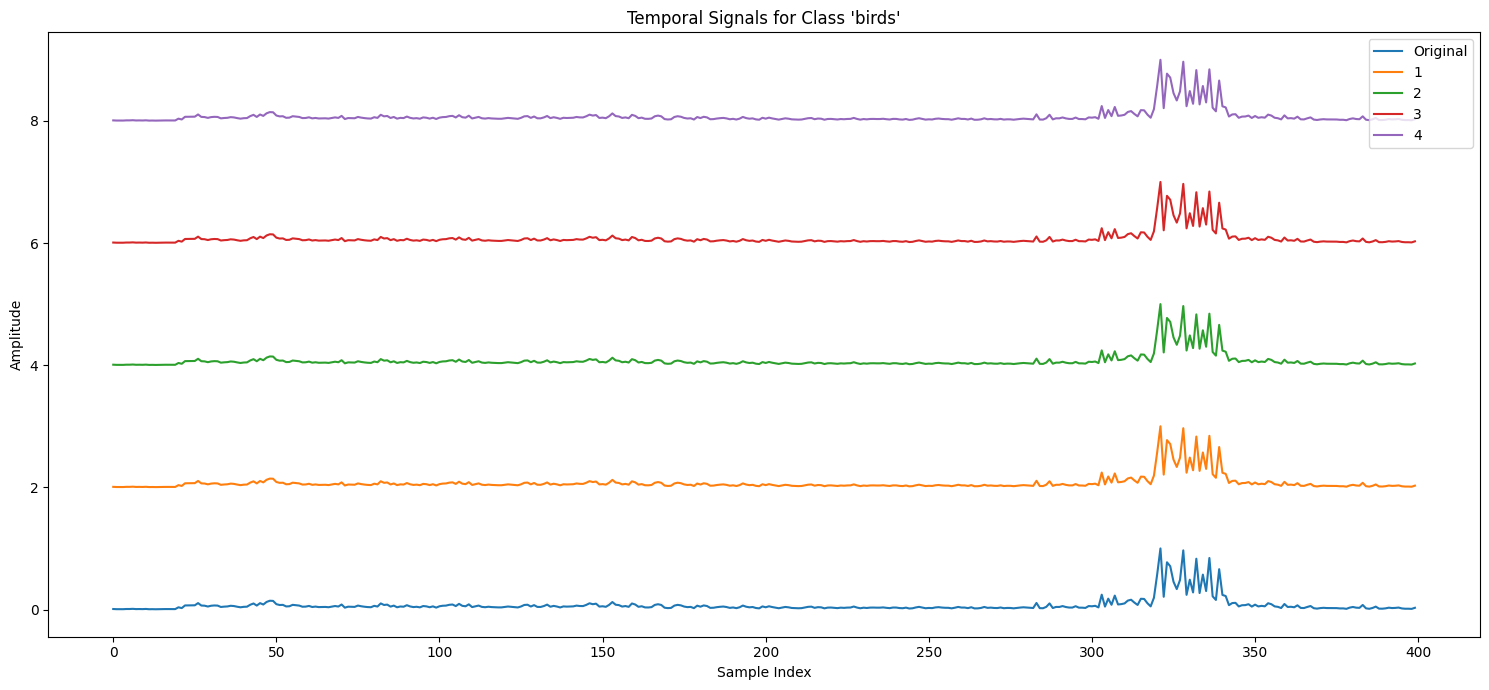

In [ ]:
# PLOT THE FEATURE VECTORS AFTER TRANSFORMATION

myds.mod_data_aug(["add_bg", "add_echo", "15", "20"])
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)
# Génération des vecteurs de caractéristiques et des étiquettes
for s in range(myds.data_aug_factor):
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
y_aug = np.array(y_aug)

def plot_augmented_waveforms_from_X_aug(X_aug, y_aug, start_idx, classe):
    """
    Plots the waveforms of a specific sound for each augmentation type from X_aug.

    :param X_aug: Matrix containing feature vectors for all augmented sounds.
    :param y_aug: Labels corresponding to the feature matrix.
    :param classnames: List of class names in the dataset.
    :param class_to_plot: Name of the class to visualize.
    :param naudio: Number of original sounds per class.
    """
    fig, ax = plt.subplots(figsize=(15, 7))

    # Find the index of the class to plot


    # Retrieve the original and augmented sounds for the given class

    sounds = [
        X_aug[start_idx],           # Original
        X_aug[start_idx + 200], # Time Shifted
        X_aug[start_idx + 2 * 200], # Scaled
        X_aug[start_idx + 3 * 200], # Noisy
        X_aug[start_idx + 4 * 200], # Echoed
    ]

    labels = ["Original", "1", "2", "3", "4"]

    # Normalize and plot each sound
    for i, (sound, label) in enumerate(zip(sounds, labels)):
        normalized_sound = sound / np.max(np.abs(sound))  # Normalize to max amplitude of 1
        ax.plot(normalized_sound + i * 2, label=label)  # Offset each plot vertically

    ax.set_title(f"Temporal Signals for Class '{classe}'")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Specify the class you want to visualize
index = 0
classe = y_aug[index]
plot_augmented_waveforms_from_X_aug(X_aug, y_aug, index, classe)


In [15]:

# celles qui marchent : "noise", "add_bg", "scaling", "time_shift", "aug_sgram"
# celles qui marchent pas : "filter", "echo"
list_augmentation = ["original", "noise", "add_bg", "time_shift", "aug_sgram", "echo", "toremove"]
myds.mod_data_aug(list_augmentation)

nclass = dataset.nclass
naudio = dataset.naudio
featveclen = len(myds["fire", 0, "original"])



X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)
# Génération des vecteurs de caractéristiques et des étiquettes
for s in range(len(list_augmentation)):
    aug = list_augmentation[s]
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx, aug]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
y_aug = np.array(y_aug)
# remove last
X_aug = X_aug[:-400]
y_aug = y_aug[:-400]
# Sauvegarde des matrices de caractéristiques
np.save(fm_dir + "feature_matrix_2D_final.npy", X_aug)
np.save(fm_dir + "labels_2D_final.npy", y_aug)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (1200, 400)
Number of labels : 1200


Norm of the difference between X_aug[220] and X_aug[420]: 0.7751163222259051


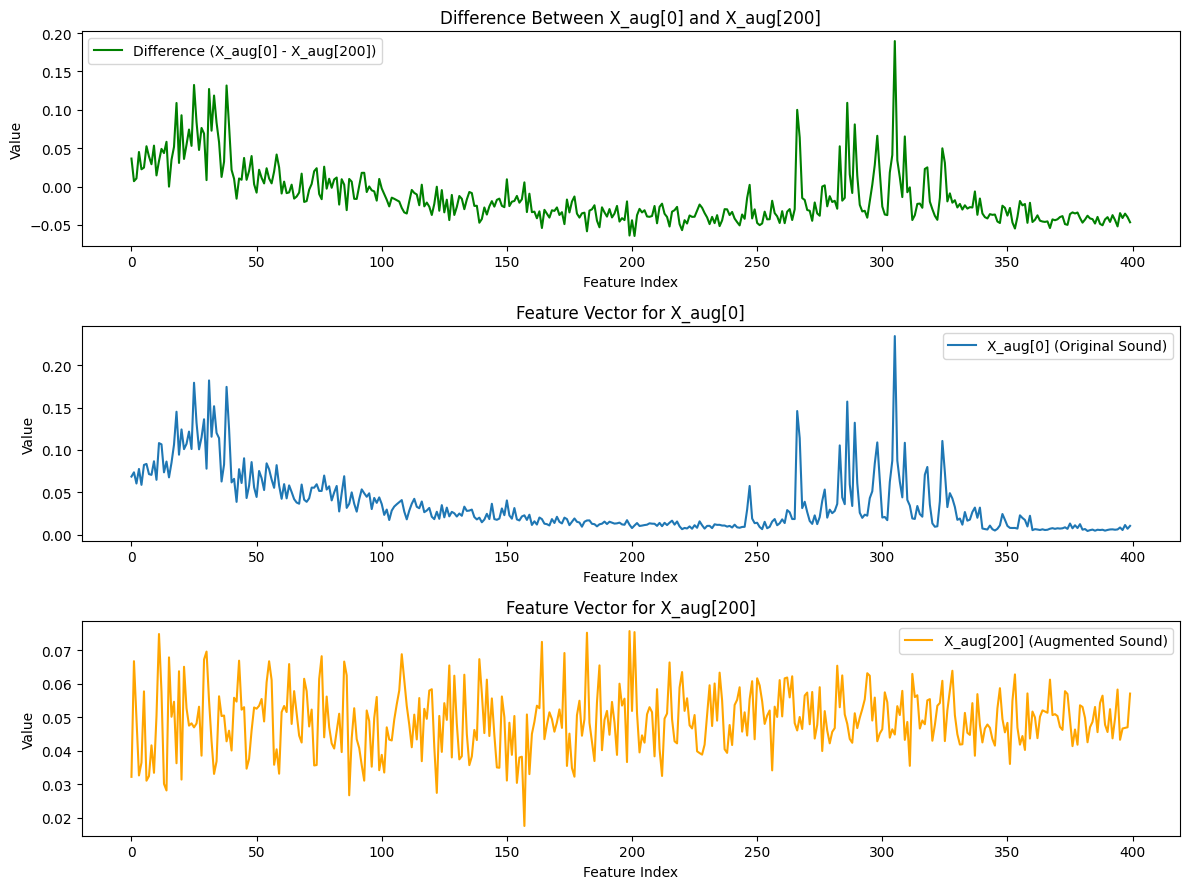

In [ ]:
X_aug = np.load(fm_dir + "feature_matrix_2D_final.npy")
y_aug = np.load(fm_dir + "labels_2D_final.npy",allow_pickle=True)

X1 = X_aug[31]
X2 = X_aug[231]

difference = X1 - X2
print(f"Norm of the difference between X_aug[220] and X_aug[420]: {np.linalg.norm(difference)}")

# Plot X_aug[0], X_aug[200], and their difference
plt.figure(figsize=(12, 9))


# Plot the difference
plt.subplot(3, 1, 1)
plt.plot(difference, label="Difference (X_aug[0] - X_aug[200])", color='green')
plt.title("Difference Between X_aug[0] and X_aug[200]")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.legend()

# Plot X_aug[0]
plt.subplot(3, 1, 2)
plt.plot(X1, label="X_aug[0] (Original Sound)")
plt.title("Feature Vector for X_aug[0]")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.legend()

# Plot X_aug[200]
plt.subplot(3, 1, 3)
plt.plot(X2, label="X_aug[200] (Augmented Sound)", color='orange')
plt.title("Feature Vector for X_aug[200]")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.legend()



plt.tight_layout()
plt.show()

FINAL MODEL SAVE

 Test Accuracy: 0.6306
Mean CV Accuracy: 0.8655


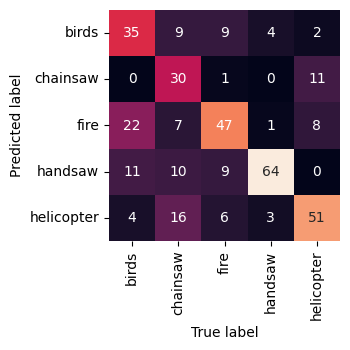

In [20]:
import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from classification.utils.utils import accuracy
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Directories
fm_dir = "data/feature_matrices/"
model_dir = "data/models/"
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Load dataset
X_augmented = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_augmented = X_augmented / np.linalg.norm(X_augmented, axis=1, keepdims=True)  # Normalization
y_augmented = np.load(fm_dir + "labels_2D_final.npy", allow_pickle=True)

X_original = X_augmented[:200]
y_original = y_augmented[:200]

start_idx = 200
augmentation_factor = len(X_augmented) // len(X_original)  # Number of transformations

# Parameters
n_per_class_test = 28  # 70% of 40 sounds per class

# Store results
results = defaultdict(list)

train_indices, test_indices = [], []
for cls in np.unique(y_original):
    class_indices = np.where(y_original == cls)[0]
    selected_indices = np.random.choice(class_indices, size=n_per_class_test, replace=False)
    remaining_indices = np.setdiff1d(class_indices, selected_indices)
    train_indices.extend(selected_indices)
    test_indices.extend(remaining_indices)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Prepare train and test sets
X_train = X_original[train_indices]
y_train = y_original[train_indices]
X_test = X_original[test_indices]
y_test = y_original[test_indices]

for i in range(1, augmentation_factor):  # Skip the original (already included)
    augmented_train_indices = start_idx + train_indices + (i - 1) * len(X_original)
    X_train = np.vstack([X_train, X_augmented[augmented_train_indices]])
    y_train = np.concatenate([y_train, y_augmented[augmented_train_indices]])

    augmented_test_indices = start_idx + test_indices + (i - 1) * len(X_original)
    X_test = np.vstack([X_test, X_augmented[augmented_test_indices]])
    y_test = np.concatenate([y_test, y_augmented[augmented_test_indices]])

# Dimension reduction
rf_dim_reducer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dim_reducer.fit(X_train, y_train)
importances = rf_dim_reducer.feature_importances_
top_features_idx = np.argsort(importances)[::-1][:200]
X_train = X_train[:, top_features_idx]
X_test = X_test[:, top_features_idx]
    
# Train the Random Forest model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model
predict = model.predict(X_test)
test_accuracy = accuracy(predict, y_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)


# Print results
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")
show_confusion_matrix(predict, y_test, classnames)

# SAVE THE MODEL
filename = "model.pickle"
pickle.dump(model, open(model_dir + filename, "wb"))

In [ ]:
import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from classification.utils.utils import accuracy
from collections import defaultdict

# Directories
fm_dir = "data/feature_matrices/"
model_dir = "data/models/"
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Load dataset
X_augmented = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_augmented = X_augmented / np.linalg.norm(X_augmented, axis=1, keepdims=True)  # Normalization
y_augmented = np.load(fm_dir + "labels_2D_final.npy", allow_pickle=True)

X_original = X_augmented[:200]
y_original = y_augmented[:200]

# Parameters
n_iterations = 50
n_per_class_test = 28  # 70% of 40 sounds per class

# Store results
results = defaultdict(list)

for iteration in range(n_iterations):
    train_indices, test_indices = [], []
    for cls in np.unique(y_original):
        class_indices = np.where(y_original == cls)[0]
        selected_indices = np.random.choice(class_indices, size=n_per_class_test, replace=False)
        remaining_indices = np.setdiff1d(class_indices, selected_indices)
        train_indices.extend(selected_indices)
        test_indices.extend(remaining_indices)

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    # Prepare train and test sets
    X_train = X_original[train_indices]
    y_train = y_original[train_indices]
    X_test = X_original[test_indices]
    y_test = y_original[test_indices]

    start_idx = 200
    augmentation_factor = len(X_augmented) // len(X_original)  # Number of transformations

    for i in range(1, augmentation_factor):  # Skip the original (already included)
        augmented_test_indices = start_idx + test_indices + (i - 1) * len(X_original)
        X_test = np.vstack([X_test, X_augmented[augmented_test_indices]])
        y_test = np.concatenate([y_test, y_augmented[augmented_test_indices]])

    # Train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate model
    predict = model.predict(X_test)
    test_accuracy = accuracy(predict, y_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)

    # Store results
    results["test_accuracy"].append(test_accuracy)
    results["cv_accuracy"].append(mean_cv_accuracy)

# Calculate mean and std of results
mean_test_accuracy = np.mean(results["test_accuracy"])
std_test_accuracy = np.std(results["test_accuracy"])
mean_cv_accuracy = np.mean(results["cv_accuracy"])
std_cv_accuracy = np.std(results["cv_accuracy"])

# Print results
print("Mean Results over 10 iterations:")
print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")


Mean Results over 10 iterations:
Mean Test Accuracy: 0.5005 ± 0.0315
Mean CV Accuracy: 0.4783 ± 0.0352


<font size=5 color=#009999> 2.8. Debriefing </font> <br>
**Questions** : 

1) from what we have done in this notebook, can you already identify some weaknesses in the feature vector computation and classification pipeline? You can make a list here below, and eventually write some short ideas for improvement. This will help you later :)
2) Do you remember what is the time duration of a feature vector? What happens if no sound is produced during the acquisition time of a feature vector?

MEAN ACCURACY ON 100 ITERATIONS

In [21]:

import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from classification.utils.utils import accuracy
from collections import defaultdict

# celles qui marchent : "noise", "add_bg", "scaling", "time_shift", "aug_sgram"
# celles qui marchent pas : "filter", "echo"
list_augmentation = ["original", "noise", "add_bg", "time_shift", "aug_sgram", "echo", "toremove"]
myds.mod_data_aug(list_augmentation)

nclass = dataset.nclass
naudio = dataset.naudio
featveclen = len(myds["fire", 0, "original"])



X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)
# Génération des vecteurs de caractéristiques et des étiquettes
for s in range(len(list_augmentation)):
    aug = list_augmentation[s]
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx, aug]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
y_aug = np.array(y_aug)
# remove last
X_aug = X_aug[:-400]
y_aug = y_aug[:-400]
# Sauvegarde des matrices de caractéristiques
np.save(fm_dir + "feature_matrix_2D_final.npy", X_aug)
np.save(fm_dir + "labels_2D_final.npy", y_aug)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (1200, 400)
Number of labels : 1200


In [24]:
# Augmented training set, augmented test set   FOR EACH CLASS


from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_augmented = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_augmented = X_augmented / np.linalg.norm(X_augmented, axis=1, keepdims=True) # Normalization
y_augmented = np.load(fm_dir + "labels_2D_final.npy", allow_pickle=True)

from sklearn.ensemble import RandomForestClassifier

def accuracy(pred, true):
    return accuracy_score(true, pred)

# Initialize metrics storage
test_accuracies = []
precisions_macro = []
recalls_macro = []
mean_cv_accuracies = []
std_cv_accuracies = []

# For per-class metrics
all_class_precisions = []
all_class_recalls = []
all_class_accuracies = []  # For per-class accuracies

# Number of classes (if known), or deduce from data
classes = np.unique(y_augmented)
n_classes = len(classes)

n_iterations = 20
for iteration in range(n_iterations):
    # Randomly split train/test data
    X_test, y_test, train_indices, test_indices = [], [], [], []
    for cls in np.unique(y_original):
        class_indices = np.where(y_original == cls)[0]
        selected_indices = np.random.choice(class_indices, size=n_per_class_test, replace=False)
        remaining_indices = np.setdiff1d(class_indices, selected_indices)

        train_indices.extend(selected_indices)
        test_indices.extend(remaining_indices)

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    X_train = X_augmented[train_indices]
    y_train = y_augmented[train_indices]

    X_test = X_augmented[test_indices]
    y_test = y_augmented[test_indices]

    start_idx = 200
    augmentation_factor = len(X_augmented) // len(X_original)
    for i in range(1, augmentation_factor):
        augmented_train_indices = start_idx + train_indices + (i - 1) * len(X_original)
        X_train = np.vstack([X_train, X_augmented[augmented_train_indices]])
        y_train = np.concatenate([y_train, y_augmented[augmented_train_indices]])

        augmented_test_indices = start_idx + test_indices + (i - 1) * len(X_original)
        X_test = np.vstack([X_test, X_augmented[augmented_test_indices]])
        y_test = np.concatenate([y_test, y_augmented[augmented_test_indices]])

    # Dimension reduction
    rf_dim_reducer = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_dim_reducer.fit(X_train, y_train)
    importances = rf_dim_reducer.feature_importances_
    top_features_idx = np.argsort(importances)[::-1][:200]
    X_train_reduced = X_train[:, top_features_idx]
    X_test_reduced = X_test[:, top_features_idx]

    # Train the Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train_reduced, y_train)

    # Evaluate the model
    predict = model.predict(X_test_reduced)
    test_accuracy = accuracy(predict, y_test)
    precision_macro = precision_score(y_test, predict, average='macro')
    recall_macro = recall_score(y_test, predict, average='macro')
    cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy = np.std(cv_scores)

    # Per-class precision and recall
    precision_per_class = precision_score(y_test, predict, average=None, labels=classes)
    recall_per_class = recall_score(y_test, predict, average=None, labels=classes)
    cm = confusion_matrix(y_test, predict, labels=classes)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

    # Store results
    test_accuracies.append(test_accuracy)
    precisions_macro.append(precision_macro)
    recalls_macro.append(recall_macro)
    mean_cv_accuracies.append(mean_cv_accuracy)
    std_cv_accuracies.append(std_cv_accuracy)

    all_class_precisions.append(precision_per_class)
    all_class_recalls.append(recall_per_class)
    all_class_accuracies.append(accuracy_per_class)

    # Print progress
    print(f"Iteration {iteration + 1}/{n_iterations}: Test Accuracy = {test_accuracy:.4f}")

# Compute final metrics
final_test_accuracy = np.mean(test_accuracies)
final_test_accuracy_std = np.std(test_accuracies)

final_precision = np.mean(precisions_macro)
final_precision_std = np.std(precisions_macro)

final_recall = np.mean(recalls_macro)
final_recall_std = np.std(recalls_macro)

final_mean_cv_accuracy = np.mean(mean_cv_accuracies)
final_mean_cv_accuracy_std = np.std(mean_cv_accuracies)

final_std_cv_accuracy = np.mean(std_cv_accuracies)
final_std_cv_accuracy_std = np.std(std_cv_accuracies)

# Compute final per-class metrics
all_class_precisions = np.array(all_class_precisions)  # shape (n_iterations, n_classes)
all_class_recalls = np.array(all_class_recalls)        # shape (n_iterations, n_classes)
all_class_accuracies = np.array(all_class_accuracies)  # shape (n_iterations, n_classes)

final_class_precision_means = np.mean(all_class_precisions, axis=0)
final_class_precision_stds = np.std(all_class_precisions, axis=0)

final_class_recall_means = np.mean(all_class_recalls, axis=0)
final_class_recall_stds = np.std(all_class_recalls, axis=0)

final_class_accuracy_means = np.mean(all_class_accuracies, axis=0)
final_class_accuracy_stds = np.std(all_class_accuracies, axis=0)

# Print final results with standard deviations
print("\nFinal Results after 100 iterations:")
print(f"Test Accuracy: {final_test_accuracy:.4f} ± {final_test_accuracy_std:.4f}")
print(f"Precision (macro): {final_precision:.4f} ± {final_precision_std:.4f}")
print(f"Recall (macro): {final_recall:.4f} ± {final_recall_std:.4f}")
print(f"Mean CV Accuracy: {final_mean_cv_accuracy:.4f} ± {final_mean_cv_accuracy_std:.4f}")
print(f"Std CV Accuracy: {final_std_cv_accuracy:.4f} ± {final_std_cv_accuracy_std:.4f}")

print("\nPer-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"Class {cls}:")
    print(f"  Precision: {final_class_precision_means[i]:.4f} ± {final_class_precision_stds[i]:.4f}")
    print(f"  Recall: {final_class_recall_means[i]:.4f} ± {final_class_recall_stds[i]:.4f}")
    print(f"  Accuracy: {final_class_accuracy_means[i]:.4f} ± {final_class_accuracy_stds[i]:.4f}")


Iteration 1/20: Test Accuracy = 0.6722
Iteration 2/20: Test Accuracy = 0.6167
Iteration 3/20: Test Accuracy = 0.6333
Iteration 4/20: Test Accuracy = 0.6417
Iteration 5/20: Test Accuracy = 0.5972
Iteration 6/20: Test Accuracy = 0.7083
Iteration 7/20: Test Accuracy = 0.6167
Iteration 8/20: Test Accuracy = 0.6611
Iteration 9/20: Test Accuracy = 0.6611
Iteration 10/20: Test Accuracy = 0.6917
Iteration 11/20: Test Accuracy = 0.6389
Iteration 12/20: Test Accuracy = 0.6528
Iteration 13/20: Test Accuracy = 0.6139
Iteration 14/20: Test Accuracy = 0.6306
Iteration 15/20: Test Accuracy = 0.6083
Iteration 16/20: Test Accuracy = 0.6917
Iteration 17/20: Test Accuracy = 0.6167
Iteration 18/20: Test Accuracy = 0.6000
Iteration 19/20: Test Accuracy = 0.6028
Iteration 20/20: Test Accuracy = 0.6417

Final Results after 100 iterations:
Test Accuracy: 0.6399 ± 0.0319
Precision (macro): 0.6470 ± 0.0326
Recall (macro): 0.6399 ± 0.0319
Mean CV Accuracy: 0.8645 ± 0.0086
Std CV Accuracy: 0.1230 ± 0.0117

Per-Cl

In [10]:
# Augmented training set, , augmented test set

X_augmented = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_augmented = X_augmented / np.linalg.norm(X_augmented, axis=1, keepdims=True) # Normalization
y_augmented = np.load(fm_dir + "labels_2D_final.npy",allow_pickle=True)

from sklearn.metrics import precision_score, recall_score

# Initialize metrics storage
test_accuracies = []
precisions = []
recalls = []
mean_cv_accuracies = []
std_cv_accuracies = []

# Run 100 iterations
n_iterations = 20
for iteration in range(n_iterations):
    # Randomly split train/test data
    X_test, y_test, train_indices, test_indices = [], [], [], []
    for cls in np.unique(y_original):
        class_indices = np.where(y_original == cls)[0]
        selected_indices = np.random.choice(class_indices, size=n_per_class_test, replace=False)
        remaining_indices = np.setdiff1d(class_indices, selected_indices)

        train_indices.extend(selected_indices)
        test_indices.extend(remaining_indices)

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)

    X_train = X_augmented[train_indices]
    y_train = y_augmented[train_indices]

    X_test = X_augmented[test_indices]
    y_test = y_augmented[test_indices]

    start_idx = 200
    augmentation_factor = len(X_augmented) // len(X_original)
    for i in range(1, augmentation_factor):
        augmented_train_indices = start_idx + train_indices + (i - 1) * len(X_original)
        X_train = np.vstack([X_train, X_augmented[augmented_train_indices]])
        y_train = np.concatenate([y_train, y_augmented[augmented_train_indices]])

        augmented_test_indices = start_idx + test_indices + (i - 1) * len(X_original)
        X_test = np.vstack([X_test, X_augmented[augmented_test_indices]])
        y_test = np.concatenate([y_test, y_augmented[augmented_test_indices]])

    """
    # Dimensionality reduction
    rf_dim_reducer = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_dim_reducer.fit(X_train, y_train)
    importances = rf_dim_reducer.feature_importances_
    top_features_idx = np.argsort(importances)[::-1][:400]
    X_train_reduced = X_train[:, top_features_idx]
    X_test_reduced = X_test[:, top_features_idx]
    """
    X_train_reduced = X_train
    X_test_reduced = X_test
    # Train the Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train_reduced, y_train)

    # Evaluate the model
    predict = model.predict(X_test_reduced)
    test_accuracy = accuracy(predict, y_test)
    precision = precision_score(y_test, predict, average='macro')
    recall = recall_score(y_test, predict, average='macro')
    cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy = np.std(cv_scores)

    # Store results
    test_accuracies.append(test_accuracy)
    precisions.append(precision)
    recalls.append(recall)
    mean_cv_accuracies.append(mean_cv_accuracy)
    std_cv_accuracies.append(std_cv_accuracy)

    # Print progress
    print(f"Iteration {iteration + 1}/{n_iterations}: Test Accuracy = {test_accuracy:.4f}")

# Compute final metrics
final_test_accuracy = np.mean(test_accuracies)
final_test_accuracy_std = np.std(test_accuracies)

final_precision = np.mean(precisions)
final_precision_std = np.std(precisions)

final_recall = np.mean(recalls)
final_recall_std = np.std(recalls)

final_mean_cv_accuracy = np.mean(mean_cv_accuracies)
final_mean_cv_accuracy_std = np.std(mean_cv_accuracies)

final_std_cv_accuracy = np.mean(std_cv_accuracies)
final_std_cv_accuracy_std = np.std(std_cv_accuracies)

# Print final results with standard deviations
print("\nFinal Results after 100 iterations:")
print(f"Test Accuracy: {final_test_accuracy:.4f} ± {final_test_accuracy_std:.4f}")
print(f"Precision: {final_precision:.4f} ± {final_precision_std:.4f}")
print(f"Recall: {final_recall:.4f} ± {final_recall_std:.4f}")
print(f"Mean CV Accuracy: {final_mean_cv_accuracy:.4f} ± {final_mean_cv_accuracy_std:.4f}")
print(f"Std CV Accuracy: {final_std_cv_accuracy:.4f} ± {final_std_cv_accuracy_std:.4f}")

Iteration 1/20: Test Accuracy = 0.5800
Iteration 2/20: Test Accuracy = 0.5883
Iteration 3/20: Test Accuracy = 0.5767
Iteration 4/20: Test Accuracy = 0.5733
Iteration 5/20: Test Accuracy = 0.6033
Iteration 6/20: Test Accuracy = 0.5933
Iteration 7/20: Test Accuracy = 0.6350
Iteration 8/20: Test Accuracy = 0.6083
Iteration 9/20: Test Accuracy = 0.6617
Iteration 10/20: Test Accuracy = 0.6400
Iteration 11/20: Test Accuracy = 0.6217
Iteration 12/20: Test Accuracy = 0.6567
Iteration 13/20: Test Accuracy = 0.6450
Iteration 14/20: Test Accuracy = 0.6117
Iteration 15/20: Test Accuracy = 0.6100
Iteration 16/20: Test Accuracy = 0.5900
Iteration 17/20: Test Accuracy = 0.6017
Iteration 18/20: Test Accuracy = 0.6217
Iteration 19/20: Test Accuracy = 0.6483
Iteration 20/20: Test Accuracy = 0.6383

Final Results after 100 iterations:
Test Accuracy: 0.6152 ± 0.0267
Precision: 0.6220 ± 0.0277
Recall: 0.6152 ± 0.0267
Mean CV Accuracy: 0.8760 ± 0.0103
Std CV Accuracy: 0.1188 ± 0.0128


In [8]:
# Original training set, augmented test set

from sklearn.metrics import precision_score, recall_score

X_augmented = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_augmented = X_augmented / np.linalg.norm(X_augmented, axis=1, keepdims=True) # Normalization
y_augmented = np.load(fm_dir + "labels_2D_final.npy",allow_pickle=True)

# Initialize metrics storage
test_accuracies = []
precisions = []
recalls = []
mean_cv_accuracies = []
std_cv_accuracies = []

n_per_class_test = 20

X_original = X_augmented[:200]
y_original = y_augmented[:200]

# Run 100 iterations
n_iterations = 100
for iteration in range(n_iterations):
    # Randomly split train/test data
    X_test, y_test, train_indices, test_indices = [], [], [], []
    for cls in np.unique(y_original):
        class_indices = np.where(y_original == cls)[0]
        selected_indices = np.random.choice(class_indices, size=n_per_class_test, replace=False)
        remaining_indices = np.setdiff1d(class_indices, selected_indices)

        train_indices.extend(selected_indices)
        test_indices.extend(remaining_indices)

    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    X_train = X_augmented[train_indices]
    y_train = y_augmented[train_indices]

    X_test = X_augmented[test_indices]
    y_test = y_augmented[test_indices]

    start_idx = 200
    augmentation_factor = len(X_augmented) // len(X_original)
    for i in range(1, augmentation_factor):
        augmented_test_indices = start_idx + test_indices + (i - 1) * len(X_original)
        X_test = np.vstack([X_test, X_augmented[augmented_test_indices]])
        y_test = np.concatenate([y_test, y_augmented[augmented_test_indices]])

    """
    # Dimensionality reduction
    rf_dim_reducer = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_dim_reducer.fit(X_train, y_train)
    importances = rf_dim_reducer.feature_importances_
    top_features_idx = np.argsort(importances)[::-1][:400]
    X_train_reduced = X_train[:, top_features_idx]
    X_test_reduced = X_test[:, top_features_idx]
    """
    X_train_reduced = X_train
    X_test_reduced = X_test
    # Train the Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train_reduced, y_train)

    # Evaluate the model
    predict = model.predict(X_test_reduced)
    test_accuracy = accuracy(predict, y_test)
    precision = precision_score(y_test, predict, average='macro')
    recall = recall_score(y_test, predict, average='macro')
    cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy = np.std(cv_scores)

    # Store results
    test_accuracies.append(test_accuracy)
    precisions.append(precision)
    recalls.append(recall)
    mean_cv_accuracies.append(mean_cv_accuracy)
    std_cv_accuracies.append(std_cv_accuracy)

    # Print progress
    print(f"Iteration {iteration + 1}/{n_iterations}: Test Accuracy = {test_accuracy:.4f}")

# Compute final metrics
final_test_accuracy = np.mean(test_accuracies)
final_test_accuracy_std = np.std(test_accuracies)

final_precision = np.mean(precisions)
final_precision_std = np.std(precisions)

final_recall = np.mean(recalls)
final_recall_std = np.std(recalls)

final_mean_cv_accuracy = np.mean(mean_cv_accuracies)
final_mean_cv_accuracy_std = np.std(mean_cv_accuracies)

final_std_cv_accuracy = np.mean(std_cv_accuracies)
final_std_cv_accuracy_std = np.std(std_cv_accuracies)

# Print final results with standard deviations
print("\nFinal Results after 100 iterations:")
print(f"Test Accuracy: {final_test_accuracy:.4f} ± {final_test_accuracy_std:.4f}")
print(f"Precision: {final_precision:.4f} ± {final_precision_std:.4f}")
print(f"Recall: {final_recall:.4f} ± {final_recall_std:.4f}")
print(f"Mean CV Accuracy: {final_mean_cv_accuracy:.4f} ± {final_mean_cv_accuracy_std:.4f}")
print(f"Std CV Accuracy: {final_std_cv_accuracy:.4f} ± {final_std_cv_accuracy_std:.4f}")

Iteration 1/100: Test Accuracy = 0.5350
Iteration 2/100: Test Accuracy = 0.5317
Iteration 3/100: Test Accuracy = 0.5317
Iteration 4/100: Test Accuracy = 0.5750
Iteration 5/100: Test Accuracy = 0.6150
Iteration 6/100: Test Accuracy = 0.5700
Iteration 7/100: Test Accuracy = 0.5233
Iteration 8/100: Test Accuracy = 0.5800
Iteration 9/100: Test Accuracy = 0.5450
Iteration 10/100: Test Accuracy = 0.5217
Iteration 11/100: Test Accuracy = 0.5733
Iteration 12/100: Test Accuracy = 0.5750
Iteration 13/100: Test Accuracy = 0.5250
Iteration 14/100: Test Accuracy = 0.4967
Iteration 15/100: Test Accuracy = 0.5700
Iteration 16/100: Test Accuracy = 0.5550
Iteration 17/100: Test Accuracy = 0.5400
Iteration 18/100: Test Accuracy = 0.5083
Iteration 19/100: Test Accuracy = 0.4967
Iteration 20/100: Test Accuracy = 0.5450
Iteration 21/100: Test Accuracy = 0.5383
Iteration 22/100: Test Accuracy = 0.5967
Iteration 23/100: Test Accuracy = 0.5300
Iteration 24/100: Test Accuracy = 0.5533
Iteration 25/100: Test Ac

REST

In [ ]:
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)

#AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio2, sigma=0.02)
audio6 = AudioUtil.echo(audio2, 5)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

TRANSFORMATION ANALYZER

In [ ]:

import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from classification.utils.utils import accuracy
from collections import defaultdict

# celles qui marchent : "noise", "add_bg", "scaling", "time_shift", "aug_sgram"
# celles qui marchent pas : "filter", "echo"

# celles qui marchent : "noise", "add_bg", "scaling", "time_shift", "aug_sgram"
# celles qui marchent pas : "filter", "echo"
list_augmentation = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "echo", "toremove"]
myds.mod_data_aug(list_augmentation)

nclass = dataset.nclass
naudio = dataset.naudio
featveclen = len(myds["fire", 0, "original"])



X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)
# Génération des vecteurs de caractéristiques et des étiquettes
for s in range(len(list_augmentation)):
    aug = list_augmentation[s]
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx, aug]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
y_aug = np.array(y_aug)
# remove last
X_aug = X_aug[:-800]
y_aug = y_aug[:-800]
# Sauvegarde des matrices de caractéristiques
np.save(fm_dir + "feature_matrix_2D_final.npy", X_aug)
np.save(fm_dir + "labels_2D_final.npy", y_aug)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (4200, 400)
Number of labels : 4200


In [ ]:
from sklearn.metrics import precision_score, recall_score
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.utils import accuracy
from collections import Counter

dataset = Dataset()
classnames = dataset.list_classes()
fm_dir = "data/feature_matrices/"
model_dir = "data/models/"
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)
featveclen = len(myds["fire", 0, "original"])
nitems = len(myds)
naudio = dataset.naudio
nclass = dataset.nclass

X_aug = np.load(fm_dir + "feature_matrix_2D_final.npy")
X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True) # Normalization
y_aug = np.load(fm_dir + "labels_2D_final.npy",allow_pickle=True)

sigma_values = []
mean_accuracies = []
mean_precisions = []
mean_recalls = []
mean_cv_accuracies = []
std_cv_accuracies = []


n_iterations = 100  # Number of iterations for averaging
sounds_in_train = 28 # 70% of 40 sounds per class


X_original = X_aug[:200]
y_original = y_aug[:200]

for k in range(0, len(X_aug) // 200):
    sigma = k * 0.02  # Calculate sigma for this iteration
    sigma_values.append(sigma)
    
    X_analyzed = X_aug[200*k:200*(k+1)]
    y_analyzed = y_aug[200*k:200*(k+1)]

    # Store accuracies for this sigma
    iteration_accuracies = []
    iteration_precisions = []
    iteration_recalls = []
    iteration_cv_accuracies = []


    for iteration in range(n_iterations):
        # Randomly split train/test data
        X_test, y_test, train_indices, test_indices = [], [], [], []
        for cls in np.unique(y_original):
            class_indices = np.where(y_original == cls)[0]
            selected_indices = np.random.choice(class_indices, size=sounds_in_train, replace=False)
            remaining_indices = np.setdiff1d(class_indices, selected_indices)

            train_indices.extend(selected_indices)
            test_indices.extend(remaining_indices)

        X_train = X_analyzed[train_indices]
        y_train = y_analyzed[train_indices]
        
        X_test = X_analyzed[test_indices]
        y_test = y_analyzed[test_indices]

    #------------------------------------------------------------------------------------------------------------
    # Dimensionality reduction
    #------------------------------------------------------------------------------------------------------------

        # Train the Random Forest classifier
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2
        )
        model.fit(X_train, y_train)

        # Evaluate the model
        predict = model.predict(X_test)
        test_accuracy = accuracy(predict, y_test)
        precision = precision_score(y_test, predict, average='macro')
        #cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
        #mean_cv_accuracy = np.mean(cv_scores)
        #std_cv_accuracy = np.std(cv_scores)

        # Store metrics
        iteration_accuracies.append(test_accuracy)
        iteration_precisions.append(precision)
        #iteration_cv_accuracies.append(mean_cv_accuracy)

    # Store the mean metrics for this sigma
    mean_accuracies.append(np.mean(iteration_accuracies))
    mean_precisions.append(np.mean(iteration_precisions))
    #mean_cv_accuracies.append(np.mean(iteration_cv_accuracies))
    #std_cv_accuracies.append(np.std(iteration_cv_accuracies))

    # Print results for this sigma
    print(f"Amplitude limit: {sigma:.3f}, Mean Test Accuracy: {mean_accuracies[-1]:.4f}, "
          f"Mean Precision: {mean_precisions[-1]:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, mean_accuracies, marker='o', linestyle='-', label='Test accuracy (mean on 100 iterations)')
plt.plot(sigma_values, mean_precisions, marker='s', linestyle='--', label='Precision (mean on 100 iterations)')
plt.xlabel('Amplitude limit of the background sounds')
plt.ylabel('Metric value')
plt.title('Effect of background sounds amplitude on performances')
plt.grid(True)
plt.legend()
plt.show()

Amplitude limit: 0.000, Mean Test Accuracy: 0.6705, Mean Precision: 0.6868
Amplitude limit: 0.020, Mean Test Accuracy: 0.6202, Mean Precision: 0.6368
Amplitude limit: 0.040, Mean Test Accuracy: 0.5865, Mean Precision: 0.5971
Amplitude limit: 0.060, Mean Test Accuracy: 0.5428, Mean Precision: 0.5523
Amplitude limit: 0.080, Mean Test Accuracy: 0.5777, Mean Precision: 0.5844


KeyboardInterrupt: 